In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# SELLER ANALYSIS

Computing the P&L of each seller where we need the
* Revenue
* Cost
* Profit

Where theres
* a 10% fee per sale
* 80 BRL subscription fee per month
* a review cost of ```{1: 100, 2: 50, 3: 40, 4: 0, 5: 0}``` as key and cost in BRL as value

In [7]:
def get_review_score(self):
    """
    Returns a DataFrame with:
    'seller_id', 'share_of_five_stars', 'share_of_one_stars', 'review_score', 'cost_of_reviews'
    """

    orders_reviews = self.order.get_review_score()
    orders_sellers = self.data['order_items'][['order_id', 'seller_id'
                                               ]].drop_duplicates()

    df = orders_sellers.merge(orders_reviews, on='order_id')

    df['cost_of_review'] = df.review_score.map({
        1: 100,
        2: 50,
        3: 40,
        4: 0,
        5: 0
    })

    df_grouped_by_sellers = df.groupby('seller_id', as_index=False).agg({
        'dim_is_one_star':
        'mean',
        'dim_is_five_star':
        'mean',
        'review_score':
        'mean',
        'cost_of_review':
        'sum'
    })
    df_grouped_by_sellers.columns = [
        'seller_id', 'share_of_one_stars', 'share_of_five_stars',
        'review_score', 'cost_of_reviews'
    ]

    return df_grouped_by_sellers

In [8]:
def get_training_data(self):
    """
    Returns a DataFrame with:
    ['seller_id', 'seller_city', 'seller_state', 'delay_to_carrier',
    'wait_time', 'date_first_sale', 'date_last_sale', 'months_on_olist',
    'share_of_one_stars', 'share_of_five_stars', 'review_score',
    'cost_of_reviews', 'n_orders', 'quantity', 'quantity_per_order',
    'sales', 'revenues', 'profits']
    """
    training_set =\
        self.get_seller_features()\
            .merge(
            self.get_seller_delay_wait_time(), on='seller_id'
        ).merge(
            self.get_active_dates(), on='seller_id'
        ).merge(
            self.get_review_score(), on='seller_id'
        ).merge(
            self.get_quantity(), on='seller_id'
        ).merge(
            self.get_sales(), on='seller_id'
        )

    # Add seller economics (revenues, profits)
    olist_monthly_fee = 80
    olist_sales_cut = 0.1

    training_set['revenues'] = training_set['months_on_olist'] * olist_monthly_fee\
        + olist_sales_cut * training_set['sales']

    training_set['profits'] = training_set['revenues'] - training_set[
        'cost_of_reviews']

    return training_set

In [9]:
from olist.seller import Seller as SellerUpdated
sellers = SellerUpdated().get_training_data()

In [10]:
sellers.head(2)

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,0.333333,0.333333,3.00,140
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,0.050000,0.725000,4.55,240


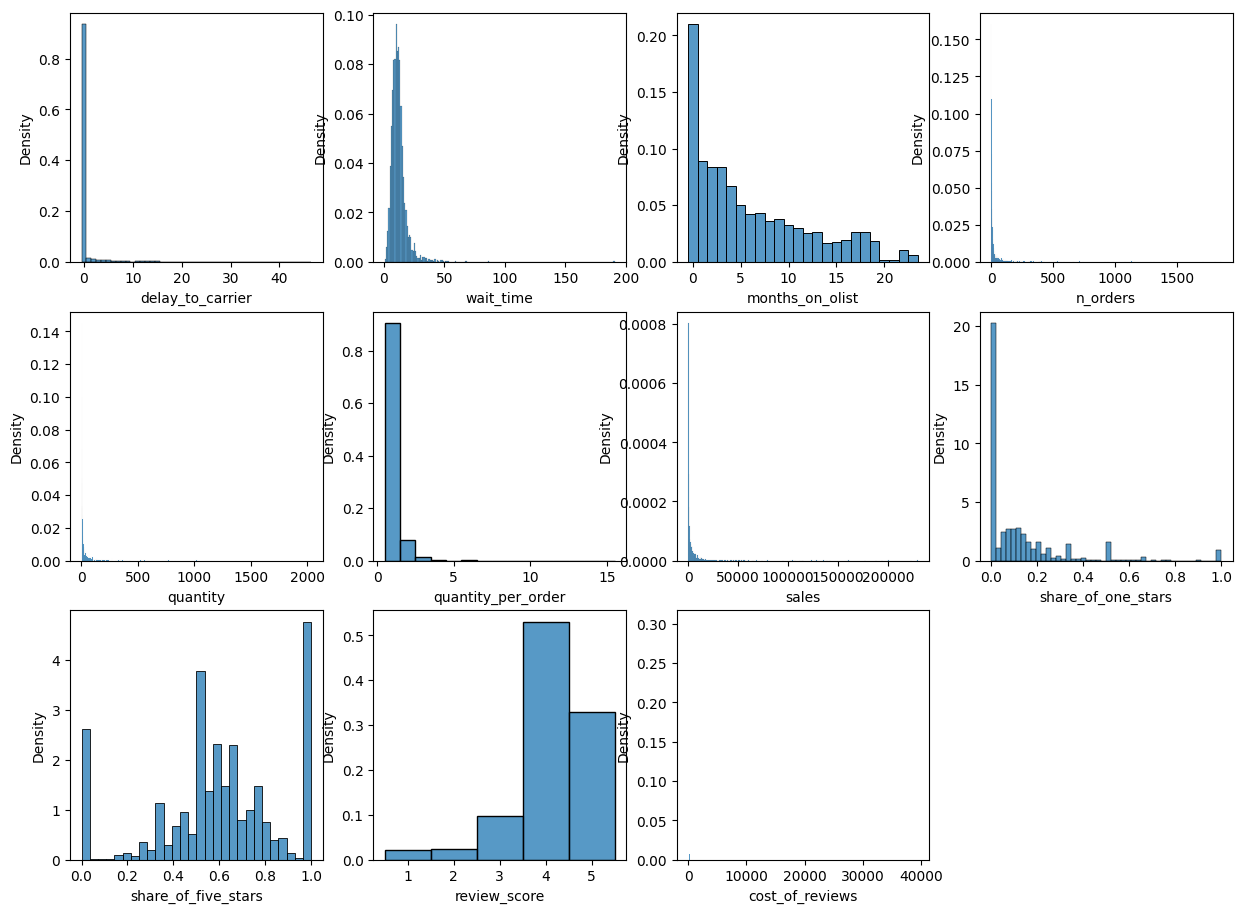

In [11]:
plt.figure(figsize=(15,11))
for (i, col) in enumerate(sellers.describe().columns):#["wait_time", "delay_to_carrier", "avg_review_score", "n_orders", "quantity", "price"]):
    plt.subplot(3,4,i+1)
    sns.histplot(sellers[col], kde=False, stat='density', discrete=[True,None][col in ['share_of_one_stars','share_of_five_stars','sales']]);

#### 💡There seems to be a group of sellers which stands out for having very low review scores

Using plotly we can create a scatterplot to investigate

In [12]:
import plotly.express as px
fig = px.scatter(data_frame = sellers[sellers['review_score'] < 4],
    x="wait_time",
    y="delay_to_carrier",
    size="sales",
    color="review_score",
    size_max = 60,
    opacity = 0.5
)
fig.show()

# Model out Review Score with a Multivariate OLS

In [13]:
def standardize(df, features):
    df_standardized = df.copy()
    for f in features:
        mu = df[f].mean()
        sigma = df[f].std()
        df_standardized[f] = df[f].map(lambda x: (x - mu) / sigma)
    return df_standardized

In [16]:
features = ['delay_to_carrier', 'wait_time', 'n_orders', 'quantity', 'quantity_per_order', 'sales']
sellers_standardized = standardize(sellers, features)
model = smf.ols(formula=f"review_score ~ {'+ '.join(features)}", data=sellers_standardized).fit()

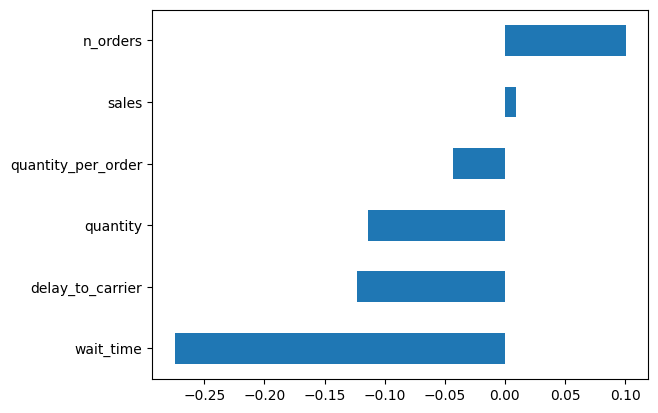

In [17]:
model.params[1:].sort_values().plot(kind='barh');

In [18]:
model.rsquared

0.19430209074601967

<AxesSubplot: xlabel='review_score', ylabel='Density'>

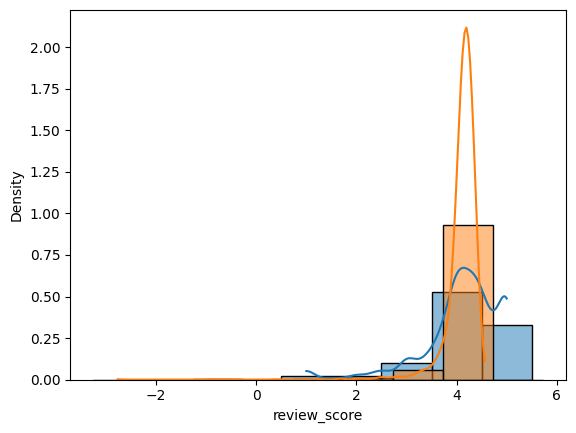

In [19]:
sns.histplot(sellers.review_score, kde=True, stat='density', discrete=True)
sns.histplot(model.predict(sellers_standardized[features]), kde=True, stat='density', discrete=True)

<AxesSubplot: ylabel='Density'>

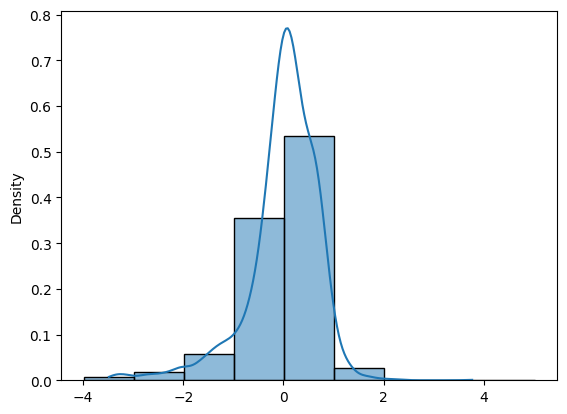

In [20]:
sns.histplot(model.resid, kde=True, stat='density', discrete=True)

In [21]:
#Adding the Seller State to the analysis
formula = 'review_score ~ C(seller_state)'
model2 = smf.ols(formula=formula, data=sellers).fit()

# top 5 coef with p-value < 0.05
from olist.utils import return_significative_coef
return_significative_coef(model2).tail()

,variable,p_value,coef
12,C(seller_state)[T.PE],0.034163,1.790505
15,C(seller_state)[T.RJ],0.028171,1.765621
1,C(seller_state)[T.BA],0.032503,1.761685
21,C(seller_state)[T.SP],0.030123,1.739509
3,C(seller_state)[T.DF],0.037168,1.698781


In [22]:
formula = 'review_score ~  sales + quantity + quantity_per_order + C(seller_state)'
model3 = smf.ols(formula=formula, data=sellers).fit()
return_significative_coef(model3).head(5+1)[1:]

,variable,p_value,coef
16,C(seller_state)[T.RN],0.014267,2.149534
4,C(seller_state)[T.ES],0.010618,2.092058
8,C(seller_state)[T.MS],0.025759,1.955813
11,C(seller_state)[T.PB],0.025146,1.936537
9,C(seller_state)[T.MT],0.034190,1.895819


In [23]:
formula = 'review_score ~ wait_time + C(seller_state)'
model3 = smf.ols(formula=formula, data=sellers).fit()
return_significative_coef(model3).head(5+1)[1:]

,variable,p_value,coef
22,wait_time,3.171865e-124,-0.04763


After adding wait time, none of the 22 dummy variables are statistically significant 

We cannot reject the hypothesis that "Seller State" has no impact on review_score, other than through **wait time**